In [110]:
# Importing the required libraries
import pandas as pd
import numpy as np

# Importing the dataset
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

# Dropping certain less important features
df.drop(columns = ['Year_of_Release', 'Publisher', 'Platform'], inplace = True)

# To view the columns with missing values
print('Feature name || Total missing values')
print(df.isna().sum())

Feature name || Total missing values
Name               2
Genre              2
NA_Sales           0
EU_Sales           0
JP_Sales           0
Other_Sales        0
Global_Sales       0
Critic_Score    8582
Critic_Count    8582
User_Score      9129
User_Count      9129
Rating          6769
dtype: int64


In [113]:
# drop two rows with missing Name values
df.dropna(subset =['Name'], axis=0, inplace=True)
df.head()

,Name,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,E
1,Super Mario Bros.,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Racing,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Sports,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,E
4,Pokemon Red/Pokemon Blue,Role-Playing,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN


Replacing the missing data with substituted values. Here, we’ll use the SimpleImputer class from the scikit-learn library to impute the columns with missing values and to impute the columns with values of type string, we’ll use CategoricalImputer from feature_engine and replace the missing values with ‘NA’ i.e. Not Available.

In [114]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df.loc[:, [ 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']] = imputer.fit_transform(df.loc[:, [ 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count']])

from feature_engine.imputation import CategoricalImputer

categorical_imputer = CategoricalImputer( imputation_method = 'frequent')
df.loc[:, ['Genre','Rating' ]] = categorical_imputer.fit_transform(df.loc[:, ['Genre','Rating' ]])


In [115]:
# To view the columns with missing values
print('Feature name || Total missing values')
print(df.isna().sum())

Feature name || Total missing values
Name            0
Genre           0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
Critic_Count    0
User_Score      0
User_Count      0
Rating          0
dtype: int64


# Variables Correlation

<AxesSubplot:>

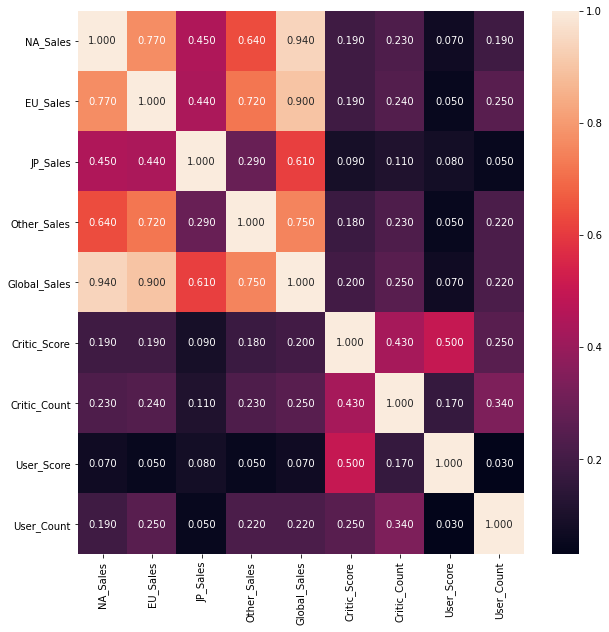

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.heatmap(df.corr().abs().round(2),annot=True,fmt= '.3f')


Splitting the dataset into Train & Test sets

In [158]:
X = df.drop('Global_Sales', axis=1) # copy dataset without the target column Global_Sales
y = df['Global_Sales'] # copy the target variable Global_Sales to y 

# Splitting the dataset into Train and Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# Saving name of the games in training and test set
games_in_training_set = X_train.loc[:,'Name']
games_in_test_set = X_test.loc[:,'Name']

# Dropping the column that contains the name of the games
X_train = X_train.drop('Name', axis=1)
X_test = X_test.drop('Name', axis=1)

Here, we initialize ‘X’ and ‘y’ where ‘X’ is the set of independent variables and ‘y’ the target variable i.e. the Global_Sales.  We save the name of the games in a separate array named  ‘games_in_training_set’ and ‘games_in_test_set’ as these names will not be of much help when predicting the global sales.

OneHotEncoding
We encode the categorical columns of ‘X’ using ColumnTransformer and OneHotEncoder from the scikit-learn library. This will assign one separate column to each category present in a categorical column of ‘X’.

In [159]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), ['Genre', 'Rating'])], remainder = 'passthrough') 
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

Building the models
We’ll implement our model i.e. the regressor using XGBRegressor (where XGB stands for extreme gradient boosting). XGBoost is an ensemble machine learning algorithm based on decision trees similar to the RandomForest algorithm. However, unlike RandomForest that makes use of fully grown trees, XGBoost combines trees that are not too deep. Also, the number of trees combined in XGBoost is more in comparison to RandomForest. Ensemble algorithms effectively combine weak learners to produce a strong learner. XGBoost has additional features focused on performance and speed when compared to gradient boosting.

In [160]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators = 200, learning_rate= 0.08)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Making predictions on the Test set
Global Sales i.e. the target variable ‘y’ for the games in the test set is predicted using the model.predict() method.

In [161]:
# Predicting test set results
y_pred = model.predict(X_test)

# Visualising actual and predicted sales
predictions = np.concatenate([games_in_test_set.values.reshape(-1, 1), y_pred.reshape(-1, 1), y_test.values.reshape(-1,1)], axis = 1)
predictions = pd.DataFrame(predictions, columns = ['Name', 'Predicted_Global_Sales', 'Actual_Global_Sales'])

In [162]:
model.score(X_test, y_test)

0.8930591120522187

In [163]:
predictions

,Name,Predicted_Global_Sales,Actual_Global_Sales
0,Mario Party 3,1.821311,1.91
1,Bullet Girls,0.058337,0.06
2,Injustice: Gods Among Us,0.142048,0.13
3,Rhythm Heaven,3.039105,3.11
4,Broken Sword II: The Smoking Mirror,0.05151,0.06
...,...,...,...
5011,Bakusou Kyoudai Let's & Go!! Eternal Wings,0.048658,0.05
5012,Darkened Skye,0.015394,0.01
5013,Burnout Paradise: The Ultimate Box,0.062339,0.07
5014,Soul Edge,1.458211,1.59


Evaluating model performance
We’ll use r2_score  and root mean squared error (RMSE) to evaluate the model performance where closer the r2_score is to 1 & lower the magnitude of RMSE, the better the model is.



In [164]:
from sklearn.metrics import r2_score, mean_squared_error
import math
r2_score = r2_score(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"r2 score of the model : {r2_score:.3f}")
print(f"Root Mean Squared Error of the model : {rmse:.3f}")

r2 score of the model : 0.893
Root Mean Squared Error of the model : 0.503


# GradientBoostingRegressor model

In [165]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 500],'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}]

grid_search_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators=200), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search_gbr.best_params_))
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(np.expm1(gbr_best_cross_val_score)))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, y_test))
print("Test set score: {:.2f}".format(np.expm1(gbr_score)))

Best parameters: {'max_depth': 5, 'max_features': 12, 'n_estimators': 500}
Best cross-validation score: 0.71
Test set score: 0.38


In [166]:
gbr_best_cross_val_score

0.5350704310919268

In [169]:
gbr_score

0.31981482245949644

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

Y_train = np.log1p(y_train)
Y_test = np.log1p(y_test)

#Parameter grid for Gradient Boosting Regressor
param_grid_gbr = [
    {'n_estimators': [200, 500],'max_features': [6, 8, 10, 12], 'max_depth': [5, 7, 9]}]

grid_search_gbr = GridSearchCV(GradientBoostingRegressor(n_estimators=200), param_grid_gbr, cv=5, scoring='neg_mean_squared_error')
grid_search_gbr.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search_gbr.best_params_))
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(gbr_best_cross_val_score))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, y_test))
print("Test set score: {:.2f}".format(gbr_score))

In [171]:
gbr_best_cross_val_score = (np.sqrt(-grid_search_gbr.best_score_))
print("Best cross-validation score: {:.2f}".format(gbr_best_cross_val_score))
gbr_score = np.sqrt(-grid_search_gbr.score(X_test, y_test))
print("Test set score: {:.2f}".format(gbr_score))

Best cross-validation score: 0.54
Test set score: 0.32


# LinearRegression Model

In [179]:
from sklearn.linear_model import LinearRegression

l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
pred_test = l_reg.predict(X_test)

print("score train :", l_reg.score(X_train, y_train))
print("score test :", l_reg.score(X_test, y_test))
print("mse test:", np.sqrt(mean_squared_error(pred_test, y_test)))

score train : 0.9999886794547679
score test : 0.9999887283843713
mse test: 0.005162787548199921


# Change from Regression to Classification model

In [200]:
print(y.describe())
bin_labels_3 = [ 'Silver', 'Gold', 'Platinum']

bin_labels_4 = [ 'Silver', 'Gold', 'Platinum', 'Diamond']

bin_labels_5 = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
bin_labels_10 = ['0', '1','2','3','4','5','6','7','8','9']#, '10','11','12','13','14']

label = pd.qcut(y, q=3, retbins = True, labels=bin_labels_3)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, label[0], test_size= 0.3, random_state=42)

# Saving name of the games in training and test set
games_in_training_set = X_train1.loc[:,'Name']
games_in_test_set = X_test1.loc[:,'Name']

# Dropping the column that contains the name of the games
X_train1 = X_train1.drop('Name', axis=1)
X_test1 = X_test1.drop('Name', axis=1)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), ['Genre', 'Rating'])], remainder = 'passthrough') 
X_train1 = ct.fit_transform(X_train1)
X_test1 = ct.transform(X_test1)

count    16717.000000
mean         0.533462
std          1.547956
min          0.010000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.530000
Name: Global_Sales, dtype: float64


In [201]:
# Classification using LogisticRegession
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter = 1000, n_jobs = -1)
lg.fit(X_train1, y_train1)
lg.score(X_test1, y_test1)

0.9049043062200957